<a href="https://colab.research.google.com/github/Farmhouse121/Wilmott-Articles/blob/main/Money_Left_on_the_Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from warnings import filterwarnings ; filterwarnings('ignore',category=FutureWarning) # I don't care
from yfinance import download,Ticker
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant
from arch.univariate import ARX, GARCH, GeneralizedError
from datetime import datetime
from scipy.optimize import minimize
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
from matplotlib.ticker import Formatter

class IntegerFormatter(Formatter):
     """Class to format axis as integers."""

     def __call__(self,data,pos=None):
        return "{:,.0f}".format(data)

zero,one,two,four,three,five,ten,hundred,annualize=0e0,1e0,2e0,3e0,4e0,5e0,1e1,1e2,252e0 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns from Yahoo! Finance
ticker='SPY'
data=download(ticker,'2018-12-31','2021-12-31')         # get prices
data.index=pd.DatetimeIndex(data.index).to_period('B')  # set calendar to business days
data['Return']=data['Adj Close'].pct_change()*hundred   # compute returns including splits, dividends etc. https://help.yahoo.com/kb/adjusted-close-sln28256.html
data['LagReturn']=data['Return'].shift()                # compute returns lagged by one trading day
data.dropna(inplace=True)                               # remove any dates that are not properly 'bars', often due to holidays not properly removed
data.loc[data["Volume"]==0,"Volume"]=np.nan             # change zero volume to NA should it exist
data

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn
Date,,,,,,,,
2019-01-03,248.229996,248.570007,243.669998,244.210007,229.525406,144140700.0,-2.386278,0.104015
2019-01-04,247.589996,253.110001,247.169998,252.389999,237.213562,142628800.0,3.349588,-2.386278
2019-01-07,252.690002,255.949997,251.690002,254.380005,239.083893,103139100.0,0.788459,3.349588
2019-01-08,256.820007,257.309998,254.000000,256.769989,241.330170,102512600.0,0.939535,0.788459
2019-01-09,257.559998,258.910004,256.190002,257.970001,242.458038,95006600.0,0.467355,0.939535
...,...,...,...,...,...,...,...,...
2021-12-23,468.750000,472.190002,468.640015,470.600006,465.213684,56439700.0,0.622204,0.999868
2021-12-27,472.059998,477.309998,472.010010,477.260010,471.797455,56808600.0,1.415214,0.622204
2021-12-28,477.720001,478.809998,476.059998,476.869995,471.411896,47274600.0,-0.081721,1.415214


In [2]:
print("Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...\n")
model = ARX(data["Return"],lags=1)
model.volatility = GARCH(1, 1, 1)
model.distribution = GeneralizedError()
ged_model=model.fit(update_freq=0)
print(ged_model.summary())
print("IC = %g." % np.sqrt(ged_model.rsquared))

# save alpha
data["Alpha"]=ged_model.params[0]+ged_model.params[1]*data["LagReturn"]
data

Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...

Optimization terminated successfully    (Exit mode 0)
            Current function value: 983.3896186714732
            Iterations: 16
            Function evaluations: 146
            Gradient evaluations: 16
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.039
Mean Model:                                    AR   Adj. R-squared:                  0.038
Vol Model:                              GJR-GARCH   Log-Likelihood:               -983.390
Distribution:      Generalized Error Distribution   AIC:                           1980.78
Method:                        Maximum Likelihood   BIC:                           2013.16
                                                    No. Observations:                  754
Date:                            Tue, Nov 08 2022   Df Residuals:          

,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn,Alpha
Date,,,,,,,,,
2019-01-03,248.229996,248.570007,243.669998,244.210007,229.525406,144140700.0,-2.386278,0.104015,0.128428
2019-01-04,247.589996,253.110001,247.169998,252.389999,237.213562,142628800.0,3.349588,-2.386278,0.349978
2019-01-07,252.690002,255.949997,251.690002,254.380005,239.083893,103139100.0,0.788459,3.349588,-0.160316
2019-01-08,256.820007,257.309998,254.000000,256.769989,241.330170,102512600.0,0.939535,0.788459,0.067536
2019-01-09,257.559998,258.910004,256.190002,257.970001,242.458038,95006600.0,0.467355,0.939535,0.054096
...,...,...,...,...,...,...,...,...,...
2021-12-23,468.750000,472.190002,468.640015,470.600006,465.213684,56439700.0,0.622204,0.999868,0.048728
2021-12-27,472.059998,477.309998,472.010010,477.260010,471.797455,56808600.0,1.415214,0.622204,0.082327
2021-12-28,477.720001,478.809998,476.059998,476.869995,471.411896,47274600.0,-0.081721,1.415214,0.011777


In [3]:
# score performance for various strategies
stats=pd.DataFrame({'Strategy':[],'Ticker':[],'Sample':[],'Mean':[],'StDev':[],'Kurtosis':[],'Sharpe':[],'StdErr':[]}).set_index(['Strategy','Ticker'])

strategy='Buy and Hold'
data["Holding"]=one
data["Profit"]=data["Holding"]*data["Return"]
stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["Profit"].count()],
        "Mean":[data["Profit"].mean()],
        "StDev":[data["Profit"].std()],
        "Kurtosis":[data["Profit"].kurt()+three],
        }).set_index(["Strategy","Ticker"]))

strategy='Sign of Alpha'
data["Holding"]=np.sign(data["Alpha"])
data["Profit"]=data["Holding"]*data["Return"]
stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["Profit"].count()],
        "Mean":[data["Profit"].mean()],
        "StDev":[data["Profit"].std()],
        "Kurtosis":[data["Profit"].kurt()+three],
        }).set_index(["Strategy","Ticker"]))

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis
stats

,,Sample,Mean,StDev,Kurtosis,Sharpe,StdErr
Strategy,Ticker,,,,,,
Buy and Hold,SPY,755.0,0.101581,1.381627,19.707775,1.167141,0.587389
Sign of Alpha,SPY,755.0,0.189701,1.372294,19.504021,2.194438,0.610832


Max Gross Profit Optimizer for SPY...



,,Sample,Mean,StDev,Kurtosis,Sharpe,StdErr
Strategy,Ticker,,,,,,
Buy and Hold,SPY,755.0,0.101581,1.381627,19.707775,1.167141,0.587389
Sign of Alpha,SPY,755.0,0.189701,1.372294,19.504021,2.194438,0.610832
Max Gross Profit,SPY,755.0,0.843308,1.098687,30.228774,12.184627,1.499883


Holding,Short,Long
OptimalHolding,,
Short,27,287
Long,16,425


Precision: 59.7%; Recall: 96.4%; Accuracy 59.9%; F1 Score 73.7%.


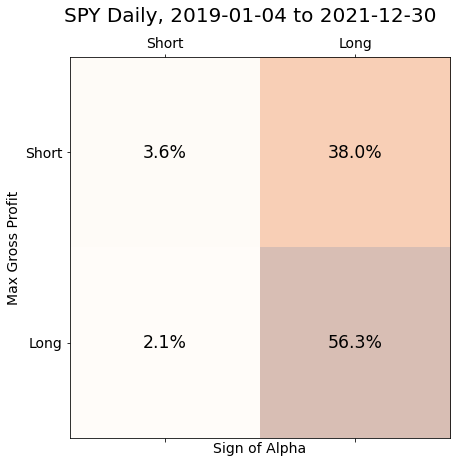

In [4]:
strategy="Max Gross Profit"
print("%s Optimizer for %s...\n" % (strategy,ticker))

def objective(holding):
    """Objective function for minimization."""
    return -sum(data["Return"]*holding)

solution=minimize(objective,np.sign(data["Alpha"]),bounds=[(-one,one)]*len(data["Alpha"]))

if solution.status:
    raise ValueError("Optimization ended with status %d." % solution.status)

else:
    data["OptimalHolding"]=solution.x
    data["OptimalProfit"]=data["OptimalHolding"]*data["Return"]
    stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["OptimalProfit"].count()],
        "Mean":[data["OptimalProfit"].mean()],
        "StDev":[data["OptimalProfit"].std()],
        "Kurtosis":[data["OptimalProfit"].kurt()+three],
        }).set_index(["Strategy","Ticker"])).drop_duplicates()

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis
display(stats)

figure,plot=pl.subplots(figsize=(7*GoldenRatio,7))
confusion=pd.crosstab(data["OptimalHolding"].apply(lambda x:"Long" if x>0 else "Short" if x<0 else "Flat"),
                      data["Holding"].apply(lambda x:"Long" if x>0 else "Short" if x<0 else "Flat")).iloc[[1,0],[1,0]]
display(confusion)
print("Precision: %.1f%%; Recall: %.1f%%; Accuracy %.1f%%; F1 Score %.1f%%." % (
    precision_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred,
    recall_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred,
    accuracy_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred,
    f1_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred
))
plot.matshow(confusion,cmap=pl.cm.Oranges,alpha=0.3)

for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plot.text(x=j,y=i,s="%.1f%%" % (confusion.iloc[i,j]*hundred/confusion.sum().sum()),va='center', ha='center', size='xx-large')
 
plot.set_xlabel('Sign of Alpha', fontsize=14)
plot.set_xticks([0,1]) ; plot.set_xticklabels(list(confusion.index),fontsize=14)
plot.set_ylabel('Max Gross Profit',fontsize=14)
plot.set_yticks([0,1]) ; plot.set_yticklabels(list(confusion.index),fontsize=14)
figure.suptitle("%s Daily, %s to %s" % (ticker,data.index[1],data.index[-1]),fontsize=20)
title="Confusion Matrix for %s" % ticker
#figure.suptitle(title, fontsize=22)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [5]:
strategy="Asymptotic Kelly"
print("%s Optimizer for %s...\n" % (strategy,ticker))

def objective(holding):
    """Objective function for minimization."""
    pnl=holding*data["Return"]
    return -(pnl.mean()-half*pnl.var())

solution=minimize(objective,np.sign(data["Alpha"]),bounds=[(-one,one)]*len(data["Alpha"]),options={"maxfun":1000000})

if solution.status:
    raise ValueError("Optimization ended with status %d.\n%s" % (solution.status,solution.message))

else:
    data["OptimalHolding"]=solution.x
    data["OptimalProfit"]=data["OptimalHolding"]*data["Return"]
    stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["OptimalProfit"].count()],
        "Mean":[data["OptimalProfit"].mean()],
        "StDev":[data["OptimalProfit"].std()],
        "Kurtosis":[data["OptimalProfit"].kurt()+three],
        }).set_index(["Strategy","Ticker"]))

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis
stats

Asymptotic Kelly Optimizer for SPY...



,,Sample,Mean,StDev,Kurtosis,Sharpe,StdErr
Strategy,Ticker,,,,,,
Buy and Hold,SPY,755.0,0.101581,1.381627,19.707775,1.167141,0.587389
Sign of Alpha,SPY,755.0,0.189701,1.372294,19.504021,2.194438,0.610832
Max Gross Profit,SPY,755.0,0.843308,1.098687,30.228774,12.184627,1.499883
Asymptotic Kelly,SPY,755.0,0.683959,0.530606,3.162383,20.462473,0.856456


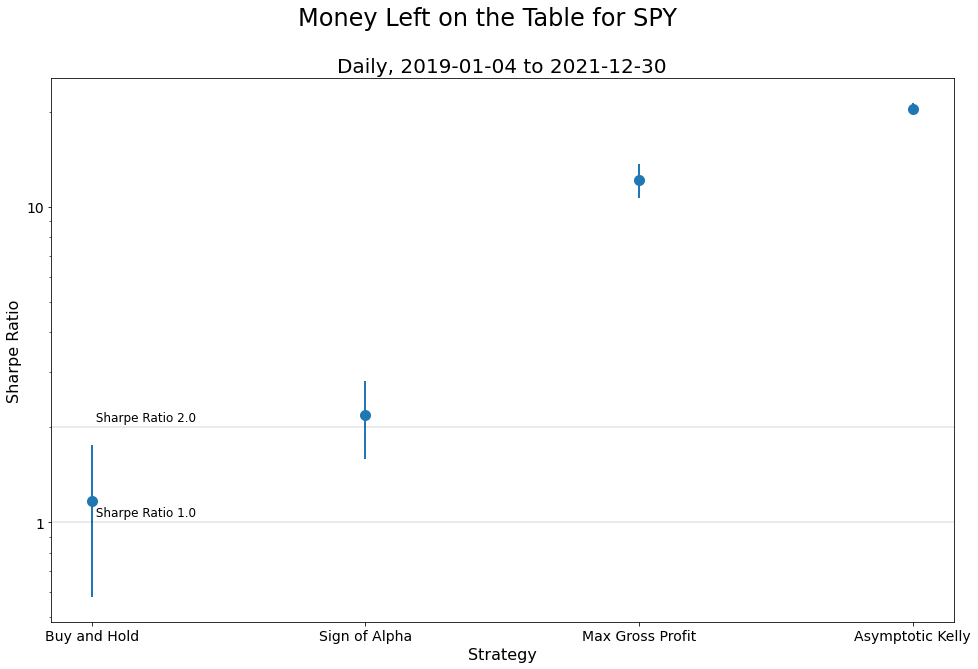

In [6]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
title="Money Left on the Table for %s" % ticker
figure.suptitle(title,fontsize=24)
plot.errorbar(list(zip(*list(stats.index)))[0],stats["Sharpe"],yerr=stats["StdErr"],fmt='o',linewidth=2,markersize=10)
plot.set_title("Daily, %s to %s" % (data.index[1],data.index[-1]),fontsize=20)
plot.set_xlabel(None);
plot.set_ylabel("Sharpe Ratio",fontsize=16)
plot.set_xlabel("Strategy",fontsize=16)
plot.axhline(one,color='black',alpha=0.1)
plot.axhline(two,color='black',alpha=0.1)
plot.set_yscale('log')
plot.set_xticklabels(list(zip(*list(stats.index)))[0],fontsize=14)
plot.text("Buy and Hold",1.05," Sharpe Ratio 1.0",fontsize=12)
plot.text("Buy and Hold",2.10," Sharpe Ratio 2.0",fontsize=12)
plot.yaxis.set_major_formatter(IntegerFormatter())
pl.tick_params(axis='y',which='major',labelsize=14)
figure.savefig(title+".png",dpi=300,bbox_inches='tight');